# Extra trees classifier

## Imports

In [1]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import classification_report
from time import time
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import load_iris
from sklearn import tree

from scipy.stats import uniform, randint

from sklearn.datasets import load_breast_cancer, load_diabetes, load_wine
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split

import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import RandomForestClassifier

## Scripts

In [2]:
%run ../util/load_data.py
%run ../util/data_visualization.py
%run ../util/outliers_statistics.py

# Data loading and manipulation

In [3]:
data = load_data("../../Data", aggregate=False)

X = data['train_data'][data['numerical_attributes'] + data['categorical_attributes']]
y = data['train_data'][data['target']]

scaler = StandardScaler()
scaler.fit(X[data['numerical_attributes']])
X[data['numerical_attributes']] = scaler.transform(X[data['numerical_attributes']])

E:\Anaconda\envs\Homework3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
E:\Anaconda\envs\Homework3\lib\site-packages\ipykernel_launcher.py:8: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  


# Hyperparameter optimization

In [4]:
classifier = RandomForestClassifier(oob_score=True, bootstrap=True, n_jobs=8, random_state=27)
hyperparameters = {
    "n_estimators": [1000, 750, 500], 
    "criterion": ['gini', 'entropy'], 
    "max_depth": [10, 100, 1000], 
#     min_samples_split=2, 
#     min_samples_leaf=1, 
#     min_weight_fraction_leaf=0.0, 
    "max_features": ['auto', 'log2'], 
    "max_leaf_nodes": [100, 500, 1000, 2000], 
#     min_impurity_decrease=0.0,   
}

In [5]:
k = StratifiedKFold(n_splits=5)
randomized_search = RandomizedSearchCV(n_iter=5, 
                                estimator=classifier, 
                                param_distributions=hyperparameters, 
                                cv=k, 
                                scoring="accuracy", 
                                verbose=2, 
                                n_jobs=8)

search = randomized_search.fit(X, np.ravel(y))

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  23 out of  25 | elapsed:  1.4min remaining:    7.3s
[Parallel(n_jobs=8)]: Done  25 out of  25 | elapsed:  1.5min finished


In [6]:
classifier.set_params(**randomized_search.best_params_)

print("Best estimator found by randomized grid search:")
print(search.best_estimator_)
print(search.best_score_)

Best estimator found by randomized grid search:
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=1000, max_features='auto', max_leaf_nodes=2000,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=8,
            oob_score=True, random_state=27, verbose=0, warm_start=False)
0.7864966486839954


# Learning curve

<module 'matplotlib.pyplot' from 'E:\\Anaconda\\envs\\Homework3\\lib\\site-packages\\matplotlib\\pyplot.py'>

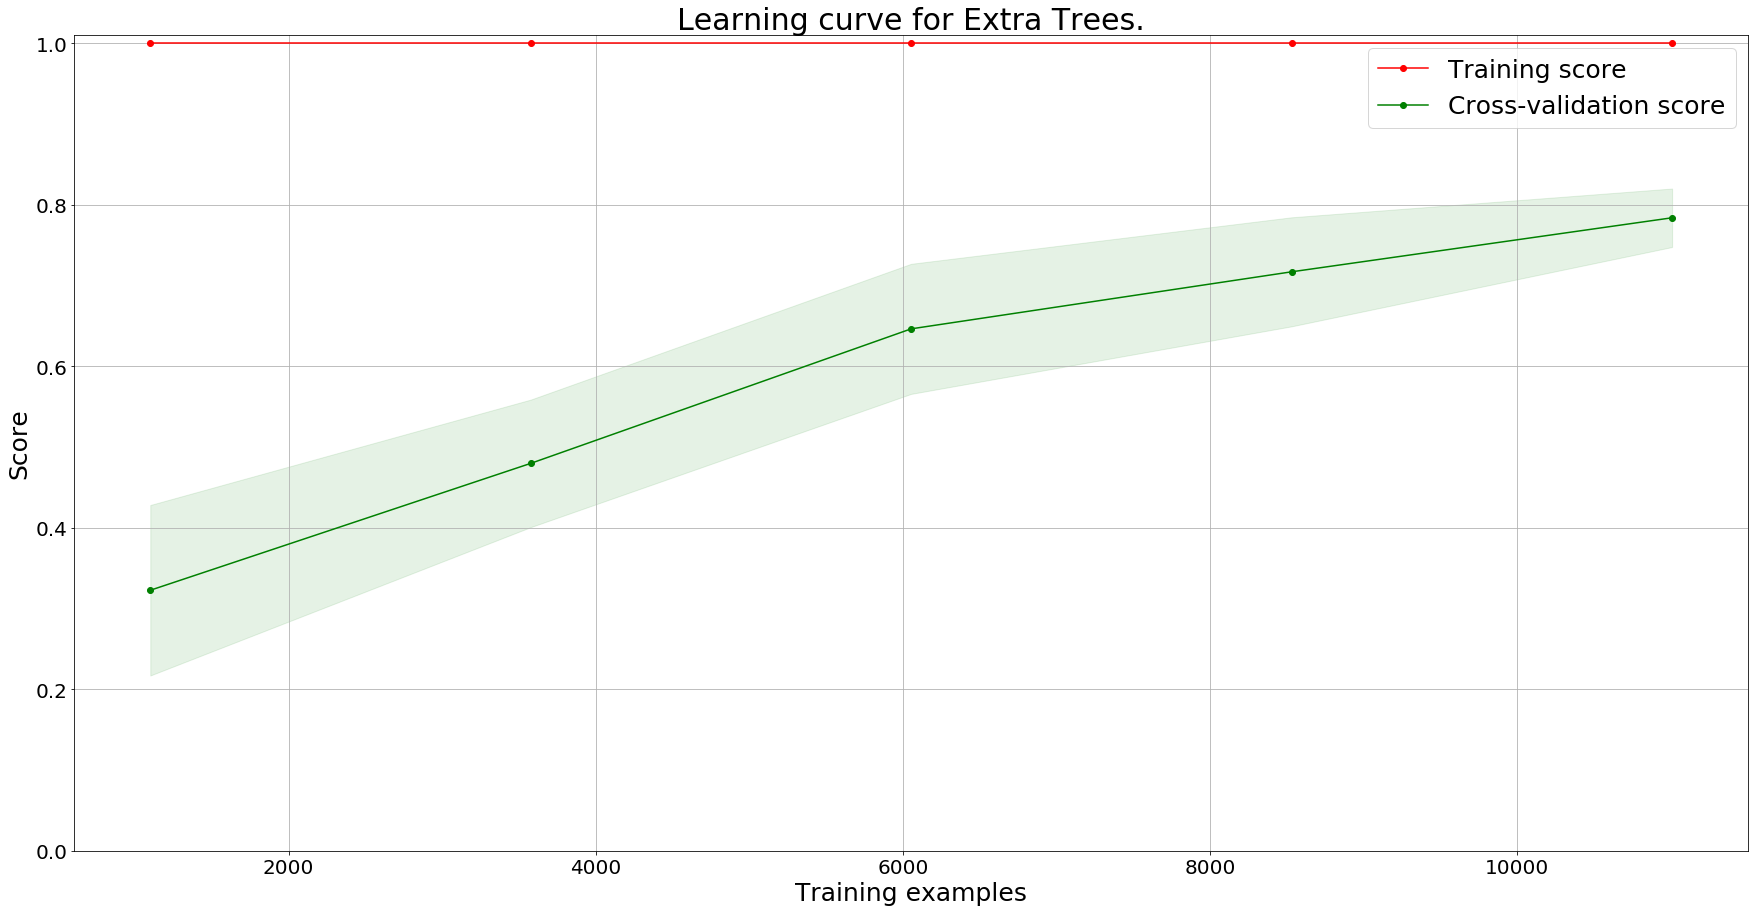

In [7]:
kfold = StratifiedKFold(n_splits = 10)
plot_learning_curve(classifier, 'Learning curve for Extra Trees.', X, np.ravel(y), ylim=(0, 1.01), cv=kfold, n_jobs=10)

# Confusion Matrix

In [ ]:
skf = StratifiedKFold(n_splits=10)
skf.get_n_splits(X, y)

y_predicted_total = [None] * len(X)

for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    classifier.fit(X_train, np.ravel(y_train))
    
    y_predicted = classifier.predict(X_test).tolist()
    for idx, index in enumerate(test_index):
        y_predicted_total[index] = y_predicted[idx]
    
plot_confusion_matrix(y, y_predicted_total, classes=list(set(y[data['target']])),
                  title='Confusion matrix for train dataset')

# Overall classification results

In [8]:
target_names = ['Class ' + str(index) for index in list(set(y[data['target'][0]].tolist()))]
print(classification_report(y, y_predicted_total, target_names=target_names))

NameError: name 'y_predicted_total' is not defined

# Tree visualization

In [ ]:
classifier.fit(X, np.ravel(y))
tree.export_graphviz(classifier.estimators_[0], out_file='tree.dot', max_depth=2, feature_names=data['numerical_attributes'] + data['categorical_attributes'])

# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')